## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 

Starter code.

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

### Part I

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

In [2]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

fatal: destination path 'imagenet10' already exists and is not an empty directory.


Check that the repository is there:

In [3]:
! ls

imagenet10  myinit_model.pt  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [7]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/orange/n07747607_10693.JPEG,9
1,imagenet10/train_set/dumbbell/n03255030_11547....,6
2,imagenet10/train_set/banana/n07753592_19976.JPEG,1
3,imagenet10/train_set/canoe/n02951358_12537.JPEG,2
4,imagenet10/train_set/football/n04254680_8599.JPEG,7


Now we will create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """
    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))


    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [10]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:43<00:00, 207.39it/s]


(224, 224, 3, 9000)
normMean = [0.5228359, 0.4798834, 0.40605333]
normStd = [0.29770732, 0.28883994, 0.31178218]


Now let's create the transforms to normalise and turn our data into tensors.

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [0]:
torch.manual_seed(0)
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

You will need to create DataLoaders for the datasets.

In [0]:

train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

classes = np.arange(0, 10)

# ConvNet Model

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        self.conv1 = nn.Sequential(
        nn.Conv2d(3,16,3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.1)
        )

        self.conv2 = nn.Sequential(
        nn.Conv2d(16,32,4),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.1)
        )

        self.conv3 = nn.Sequential(
        nn.Conv2d(32,64,4),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.1)
        )

        self.conv4 = nn.Sequential(
        nn.Conv2d(64,128,4),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.1)
        )

        # self.conv5 = nn.Sequential(
        # nn.Conv2d(48,64,4),
        # nn.ReLU(),
        # nn.MaxPool2d(2),
        # nn.Dropout2d(p=0.3)
        # )


        self.linear_layer = nn.Sequential(
        nn.Linear(21632, 512),  #26912=32*29*29   for 2 layers: 92256  4 layers: 8112 5 layers: 1600
        nn.Linear(512, num_classes),
            #nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        # out = self.conv5(out)
        # print(out)
        out = out.reshape(out.size(0),-1)
        out = self.linear_layer(out)
        # Complete the graph
        return out

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_gpu = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()

# Stochastic gradient "assumes a 4D tensor")descent
optimizer = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9)

# Question2: Visualization for different channels

In [0]:
def set_filters():
  model = model_gpu.cpu().double()
  filters = model.modules
  body_model = [i for i in model.children()][0]
  layer1 = body_model[0]    
  tensor = layer1.weight.data.numpy() 
  return tensor

In [0]:
def vis_all_filters(channel):
  
  filters = set_filters()
  if not filters.ndim==4:
      raise Exception("assumes a 4D tensor")
  if not filters.shape[-1]==3:
      raise Exception("last dim needs to be 3 to plot")
  num_kernels = filters.shape[0]
  num_cols=6
  num_rows = 1+ num_kernels // num_cols
  fig = plt.figure(figsize=(num_cols,num_rows))
  
  for i in range(filters.shape[0]):
      ax1 = fig.add_subplot(num_rows,num_cols,i+1)
      ax1.imshow(filters[i][channel], cmap="gray")
      ax1.axis('off')
      ax1.set_xticklabels([])
      ax1.set_yticklabels([])

  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


In [0]:
def vis_filters():
    print("Red Filter:\n")
    vis_all_filters(0)
    print("Green Filter:\n")
    vis_all_filters(1)
    print("Blue Filter:\n")
    vis_all_filters(2)

    if torch.cuda.is_available():
        model_gpu.cuda().float()

Visualization before training

Red Filter:



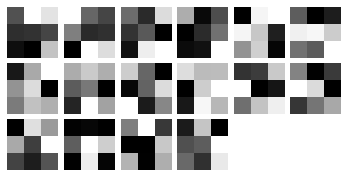

Green Filter:



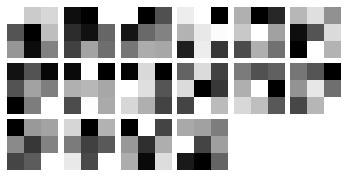

Blue Filter:



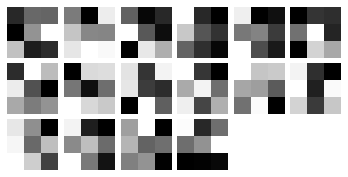

In [90]:
vis_filters()

In [0]:
training_loss = []
validation_loss = []
def train_model_epochs2(num_epochs):
    """ Trains the network for a given number of epochs on training sets."""
    
    for epoch in range(num_epochs):
        valid_loss = 0.0
        train_loss = 0.0

        # Visualising filters
        middle = num_epochs/2
        if epoch == round(middle):
          vis_filters()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model_gpu(images)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()
            train_loss += loss.item()

            if i % 10 == 9:    # prinalset every 1000 mini-batches
                print('Epoch / Batch [%d / %d] - Loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
     
        training_loss.append(train_loss/len(train_loader))
        for i, data in enumerate(valid_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model_gpu(images)

            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            valid_loss += loss.item()
            
            if i % 10 == 9:    # print every 10 mini-batches
                print('Epoch / Batch [%d / %d] - Validation Loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
        # print("Validation Loss", running_loss/valid_loss)
        validation_loss.append(valid_loss/len(valid_loader))

   

Epoch / Batch [1 / 10] - Loss: 2.304
Epoch / Batch [1 / 20] - Loss: 2.301
Epoch / Batch [1 / 30] - Loss: 2.299
Epoch / Batch [1 / 40] - Loss: 2.306
Epoch / Batch [1 / 50] - Loss: 2.297
Epoch / Batch [1 / 60] - Loss: 2.297
Epoch / Batch [1 / 70] - Loss: 2.286
Epoch / Batch [1 / 80] - Loss: 2.293
Epoch / Batch [1 / 90] - Loss: 2.289
Epoch / Batch [1 / 100] - Loss: 2.274
Epoch / Batch [1 / 110] - Loss: 2.267
Epoch / Batch [1 / 120] - Loss: 2.260
Epoch / Batch [1 / 130] - Loss: 2.249
Epoch / Batch [1 / 140] - Loss: 2.213
Epoch / Batch [1 / 150] - Loss: 2.185
Epoch / Batch [1 / 160] - Loss: 2.129
Epoch / Batch [1 / 170] - Loss: 2.060
Epoch / Batch [1 / 180] - Loss: 2.049
Epoch / Batch [1 / 190] - Loss: 2.070
Epoch / Batch [1 / 200] - Loss: 2.183
Epoch / Batch [1 / 210] - Loss: 2.076
Epoch / Batch [1 / 220] - Loss: 2.050
Epoch / Batch [1 / 230] - Loss: 1.927
Epoch / Batch [1 / 240] - Loss: 2.105
Epoch / Batch [1 / 250] - Loss: 2.031
Epoch / Batch [1 / 260] - Loss: 2.088
Epoch / Batch [1 / 27

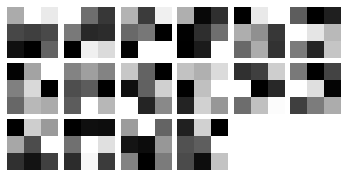

Green Filter:



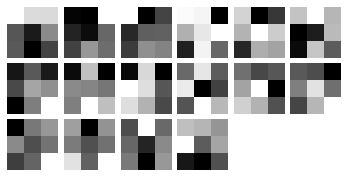

Blue Filter:



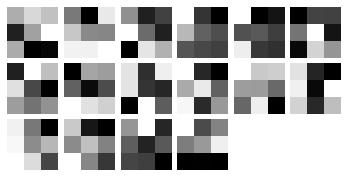

Epoch / Batch [7 / 10] - Loss: 1.380
Epoch / Batch [7 / 20] - Loss: 1.516
Epoch / Batch [7 / 30] - Loss: 1.372
Epoch / Batch [7 / 40] - Loss: 1.490
Epoch / Batch [7 / 50] - Loss: 1.586
Epoch / Batch [7 / 60] - Loss: 1.575
Epoch / Batch [7 / 70] - Loss: 1.592
Epoch / Batch [7 / 80] - Loss: 1.565
Epoch / Batch [7 / 90] - Loss: 1.418
Epoch / Batch [7 / 100] - Loss: 1.379
Epoch / Batch [7 / 110] - Loss: 1.460
Epoch / Batch [7 / 120] - Loss: 1.535
Epoch / Batch [7 / 130] - Loss: 1.496
Epoch / Batch [7 / 140] - Loss: 1.424
Epoch / Batch [7 / 150] - Loss: 1.473
Epoch / Batch [7 / 160] - Loss: 1.494
Epoch / Batch [7 / 170] - Loss: 1.429
Epoch / Batch [7 / 180] - Loss: 1.572
Epoch / Batch [7 / 190] - Loss: 1.416
Epoch / Batch [7 / 200] - Loss: 1.534
Epoch / Batch [7 / 210] - Loss: 1.464
Epoch / Batch [7 / 220] - Loss: 1.255
Epoch / Batch [7 / 230] - Loss: 1.281
Epoch / Batch [7 / 240] - Loss: 1.471
Epoch / Batch [7 / 250] - Loss: 1.485
Epoch / Batch [7 / 260] - Loss: 1.463
Epoch / Batch [7 / 27

In [92]:
import timeit
gpu_train_time = timeit.timeit(
     "train_model_epochs2(num_epochs)",
     setup="num_epochs=12",
     number=1,
     globals=globals(),
 )

# PLotting graph of training vs validation

Text(0.5, 1.0, 'Training loss vs Validation loss')

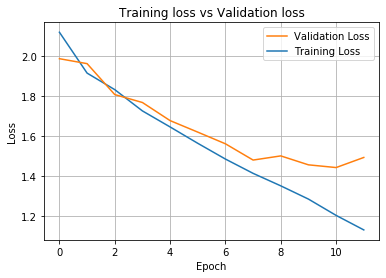

In [93]:
    train, = plt.plot(training_loss, label = "Training Loss")
    valid, = plt.plot(validation_loss, label = "Validation Loss")
    plt.legend(handles=[valid, train])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.title("Training loss vs Validation loss")

In [94]:
gpu_train_time

623.3264751120005

In [95]:
correct = 0
total = 0
first = True
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_gpu(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        if first:
          total_predicted = predicted.clone()
          total_labels = labels.clone()
          first = False
        else:
          total_predicted = torch.cat((total_predicted,predicted))
          total_labels = torch.cat((total_labels,labels))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 49 %


In [0]:
torch.save(model_gpu.state_dict(), './myinit_model.pt') 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(labels.cpu(), predicted.cpu())

Visualization after Training

Red Filter:



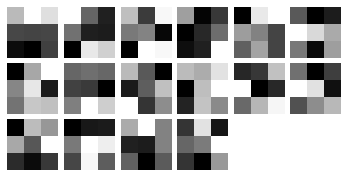

Green Filter:



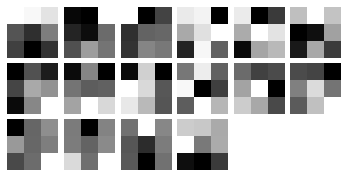

Blue Filter:



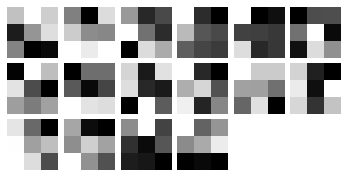

In [97]:
vis_filters()

# Question 3: Feature Maps

torch.Size([16, 254, 254])


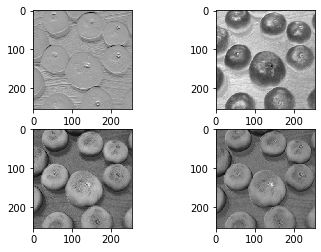

In [98]:

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
    
model_gpu.conv1[0].register_forward_hook(get_activation('conv1'))
data, _ = ins_dataset_train[0]
data.unsqueeze_(0)
model_cpu = model_gpu.cpu()
output = model_gpu(data)

act = activation['conv1'].squeeze()
print(act.size())
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap="gray")
    axarr[0,1].imshow(act[1], cmap="gray")
    axarr[1,0].imshow(act[2], cmap="gray")
    axarr[1,1].imshow(act[3], cmap="gray")

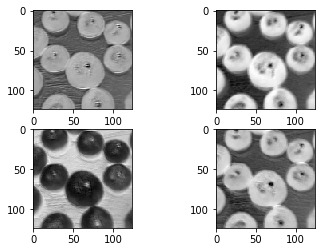

In [99]:

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model_gpu.conv2[0].register_forward_hook(get_activation('conv2'))
data, _ = ins_dataset_train[0]
data.unsqueeze_(0)
model_cpu = model_gpu.cpu()
output = model_cpu(data)

act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap="gray")
    axarr[0,1].imshow(act[1], cmap="gray")
    axarr[1,0].imshow(act[2], cmap="gray")
    axarr[1,1].imshow(act[3], cmap="gray")

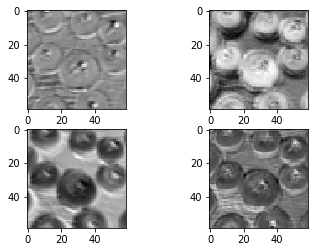

In [100]:

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model_gpu.conv3[0].register_forward_hook(get_activation('conv3'))
data, _ = ins_dataset_train[0]
data.unsqueeze_(0)
model_cpu = model_gpu.cpu()
output = model_cpu(data)

act = activation['conv3'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap="gray")
    axarr[0,1].imshow(act[1], cmap="gray")
    axarr[1,0].imshow(act[2], cmap="gray")
    axarr[1,1].imshow(act[3], cmap="gray")

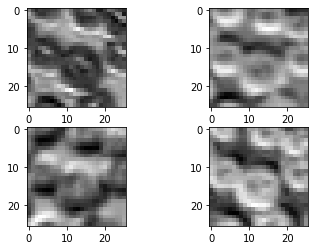

In [101]:

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model_gpu.conv4[0].register_forward_hook(get_activation('conv4'))
data, _ = ins_dataset_train[0]
data.unsqueeze_(0)
model_cpu = model_gpu.cpu()
output = model_cpu(data)

act = activation['conv4'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap="gray")
    axarr[0,1].imshow(act[1], cmap="gray")
    axarr[1,0].imshow(act[2], cmap="gray")
    axarr[1,1].imshow(act[3], cmap="gray")

Confusion matrix, without normalization


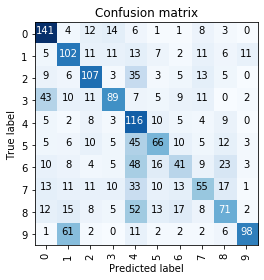

In [102]:
import itertools
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
cm = confusion_matrix(total_labels.cpu() , total_predicted.cpu())
plot_confusion_matrix(cm,classes)